<a href="https://colab.research.google.com/github/heshumi/NNTI-WS2021-NLP-Project/blob/main/Task_3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 3a) Binary neural sentiment classifier for Hindi dataset using pretrained Hindi word2vec model trained from task 1.

**Note:** In short: Just keep/load all the files of the folder 'task3' in your runtime before running the notebook of task3.

More detailed: Keep/upload the folowing files from the 'task 3' folder in the runtime before executing the notebook. 
`hindi_dataset.tsv`, `bengali_hatespeech.csv`, `bengali_hatespeech_sampled.csv`, `stopwords-bn.txt`, `stopwords-en.txt`, `stopwords-hi.txt`, `translated-bg.csv`, `translated-hi.csv`,`Synonym-hi.txt`,`Synonym-bn.txt`,`Word2Vec-hi-aug.model`, `Word2Vec-bg-aug.model`, `task3_utils.py`. Note that,
`task3_utils.py` contains all the necessary classes and functions that are required in this task 3 and those are separated as per the general guidlines of the project handout. Also if you want to skip training the sentiment classifier please load the model file cnn_hindi_model.pt, cnn_bengali_bg_model.pt and cnn_hindi_retrained_on_bengali-model.pt. 

#### Loading the required libraries  

In [35]:
!pip install emot # For emoji conversion
!pip install google_trans_new # For back translation

#### Importing the packages

In [36]:
# Imports 
import pandas as pd
import numpy as np
from math import sqrt
import random
import time
import copy
import torch.nn as nn
import torch                                                                                                                                                                                                                                                                                                                                                                            
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from task3_utils import * #separate .py file for functions and classes as instructed

#### Reading Hindi dataset for sentiment classification. Word2vec model for Hindi dataset is already trained in task 1 and will be loaded in a further cell. 

In [37]:
data_hindi = pd.read_csv('hindi_dataset.tsv', sep='\t', usecols=['text', 'task_1'])
dev_hindi, val_test = train_test_split(data_hindi, test_size = 0.3, random_state = 21)
val_hindi, test_hindi = train_test_split(val_test, test_size = 0.5, random_state = 21)

dev_hindi.reset_index(drop = True, inplace=True)
val_hindi.reset_index(drop = True, inplace=True)
test_hindi.reset_index(drop = True, inplace=True)

dev_hindi.head()

,text,task_1
0,"थाला आ गया वापिस , गाँड फाड़ दे थाला",HOF
1,#MannKiBaat देश और समाज के लिए आईने की तरह है।...,NOT
2,माननीय श्री @rajnathsingh जी को रक्षा मंत्री ब...,NOT
3,"(2/2) [Meridies ( Midday), Ante (Before) an...",NOT
4,जायरा खान ने एक्टिंग छोड़ दी क्योंकि मुसलमान ह...,HOF


#### Load the hindi dataset augmented by back traslation 

In [38]:
df_tr = pd.read_csv('translated-hi.csv', usecols=['text', 'task_1'])

# Concat dev with the translated dataset
dev_hindi = pd.concat([dev_hindi, df_tr]
                    , ignore_index=True)
dev_hindi.drop_duplicates(subset ="text", 
                     keep = 'first', inplace = True) 

print(len(dev_hindi))

6521


#### Preprocess the dataset. Here we remove the punctuations, stopwords and other non-influential words and symbols like 'http' and '@' from the beginning of a word and make word list candidates from the sentences. 

In [39]:
hi = 'stopwords-hi.txt'
bg = 'stopwords-bn.txt'
en = 'stopwords-en.txt'

In [40]:
dev_hindi['text'] = dev_hindi['text'].apply(lambda x: preprocess(x, hi, bg, en))
dev_hindi = dev_hindi.dropna()
dev_hindi = dev_hindi.reset_index(drop=True)

val_hindi['text'] = val_hindi['text'].apply(lambda x: preprocess(x, hi, bg, en))
val_hindi = val_hindi.dropna()
val_hindi = val_hindi.reset_index(drop=True)

test_hindi['text'] = test_hindi['text'].apply(lambda x: preprocess(x, hi, bg, en))
test_hindi = test_hindi.dropna()
test_hindi = test_hindi.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [41]:
len(dev_hindi)

6514

#### Augment the dataset by synonyms replacement

In [42]:
aug_n = 9 # How many times to augment the dataset
aug_w_n = 150 # Number of words to replace

np.random.seed(21)
for i in range(aug_n): # Augment 6 times
	print('Augmentation iteration #: {}'.format(i+1))
	dev_hindi = augment_dataset(dev_hindi, aug_w_n, 'Synonym-hi.txt')

Augmentation iteration #: 1
Dev size: 9026
Augmentation iteration #: 2
Dev size: 12641
Augmentation iteration #: 3
Dev size: 15118
Augmentation iteration #: 4
Dev size: 16921
Augmentation iteration #: 5
Dev size: 18347
Augmentation iteration #: 6
Dev size: 19541
Augmentation iteration #: 7
Dev size: 20587
Augmentation iteration #: 8
Dev size: 21494
Augmentation iteration #: 9
Dev size: 22295


#### Getting the statistics

In [43]:
full_df = pd.concat([dev_hindi, val_hindi, test_hindi])

print('Dataset lenght: {}'.format(len(full_df)))
print('Offensive: {}'.format(len(full_df[full_df['task_1'] == 'HOF'])))
print('Not offensive: {}'.format(len(full_df[full_df['task_1'] == 'NOT'])))
print('Training data: {}'.format(len(dev_hindi)))
print('Validation data: {}'.format(len(val_hindi)))
print('Test data: {}'.format(len(test_hindi)))

del full_df

Dataset lenght: 23694
Offensive: 10910
Not offensive: 12784
Training data: 22295
Validation data: 699
Test data: 700


#### Build the vocabulary avaialable in the dataset

In [44]:
dev_hindi.head()

,text,task_1
0,"[थाला, वापिस, गाँड, फाड़, थाला]",HOF
1,"[#mannkibaat, देश, समाज, आईने, हमें, बताता, हा...",NOT
2,"[माननीय, श्री, रक्षा, मंत्री, बनने, हार्दिक, श...",NOT
3,"[2confusion, meridies, middayconfusion, ante, ...",NOT
4,"[जायरा, खान, एक्टिंग, छोड़, क्योंकि, मुसलमान, ...",HOF


In [45]:
hindi_V = build_vocab(dev_hindi)
summ = sum(hindi_V.values())
len(hindi_V)

20519

#### Developing a dictionary that represents the one hot encoding of the words in the vocabulary

In [46]:
pad = 1
onehot_dict_hindi= build_onehot(hindi_V, pad)

In [47]:
# print one hot of padding
print(onehot_dict_hindi[' '])

[0. 0. 0. ... 0. 0. 1.]


#### Getting the insigths of the sentences in sense of the number of words in a sentence. 

count    22295.000000
mean        17.538551
std          8.490546
min          1.000000
25%         11.000000
50%         17.000000
75%         24.000000
max         58.000000
dtype: float64

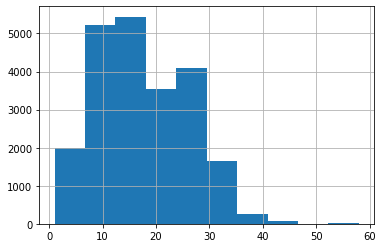

In [48]:
text_len = [len(x) for x in dev_hindi['text']]
pd.Series(text_len).hist()
pd.Series(text_len).describe()

#### From the Histogram above we see that 75% of the sentences are covered with 23 being the size of the words in sentences. We select 35 as the maximum number of words in a sentence considering factor like outliers.

#### Set the hyperparameters for Sentiment classification of Hindi Dataset

In [49]:
# Set hyperparameters
batch_size = 16
min_sen_length=35
epochs = 10
embedding_size = 300
input_size_hi = len(hindi_V) #For embedding 


#### Then we create a custom Hindi dataset and data loader to train the binary classifier

#### Define Data loader for Hindi dataset

In [53]:
train_dataset = MyDataset(dev_hindi, min_sen_length, onehot_dict_hindi)
val_dataset = MyDataset(val_hindi, min_sen_length, onehot_dict_hindi)
test_dataset = MyDataset(test_hindi, min_sen_length, onehot_dict_hindi)

In [54]:
trainloader_hindi = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
valloader_hindi = DataLoader(val_dataset, batch_size= batch_size, shuffle=True)
testloader_hindi = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

i1, l1 = next(iter(valloader_hindi))
print(i1.shape)

torch.Size([16, 35, 20520])


#### Create same Word2Vec model architecture as defined in task 1. We are not gonna train the Word2Vec model again rather will load the Hindi Word2Vec model as instructed in the next cell. 

In [55]:
word2vec_model = Word2Vec(input_size_hi, embedding_size)  

#### Load the pretrained word2vec model. Also, add a new column to the first hidden layer for allwoing weights of padding. (Please make sure the pretrained model from task 1 'word2vec_model' is avaialable in the runtime)

In [56]:
# word2vec_model.cuda()
word2vec_model.load_state_dict(torch.load('/content/Word2Vec-hi-aug.model'))
word2vec_model.cuda()
word2vec_model.eval()
# Add a column to the first hidden layer matrix of the word2vec model for the padding embedding.
embeddings = torch.cat((word2vec_model.fc1.weight.detach(), torch.zeros(embedding_size).unsqueeze(1).cuda()), dim = 1) # init the padding embedding by zeros
biases = word2vec_model.fc1.bias.detach()

#### Set more hyperparameters to train binary sentiment classifier

In [57]:
n_filters = 35
filter_sizes = [2, 3, 5]
output_dim = 1
dropout = 0.5
N_EPOCHS = 10

#### Convolution based model architecture for Hindi sentiment classification

#### Create CNN model instance by importing CNN_HINDI defined in task2_utils file.

In [58]:
cnn = CNN_HINDI(input_size_hi, embedding_size, n_filters, filter_sizes, output_dim, dropout)

cnn.double()
cnn.cuda()

CNN_HINDI(
  (embedding): Linear(in_features=20520, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(2, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copy the pre-trained embeddings weights and biases as the Hindi CNN model's embedding layer

In [59]:
cnn.embedding.bias.data.copy_(biases)
cnn.embedding.weight.data.copy_(embeddings)

tensor([[ 0.2999,  0.2709,  0.5674,  ...,  0.3064,  0.8147,  0.0000],
        [ 0.9373,  0.3905,  0.2313,  ...,  0.8536,  0.6029,  0.0000],
        [ 0.2789,  0.5106,  0.4444,  ...,  0.2224,  0.2421,  0.0000],
        ...,
        [-0.1277, -0.3497, -0.6975,  ...,  0.4914, -0.0584,  0.0000],
        [ 0.1116,  1.2497,  0.1835,  ...,  0.9383,  0.9304,  0.0000],
        [ 0.7151,  0.4270,  0.1555,  ...,  0.5527,  0.0665,  0.0000]],
       device='cuda:0', dtype=torch.float64)

#### Define optimizer and criterion for sentiment classification training

In [60]:
optimizer = optim.Adam(cnn.parameters())

criterion = nn.BCEWithLogitsLoss()

#### Training the binary sentiment classification model

In [62]:
# Keep 'train_models = False' if you don't want to train the models, but want to load them
train_models = False

In [63]:
if train_models:
  # Keeping loss and accuracy history of epochs for visualiztion
  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  # Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
  stop_criterion = 0
  best_valid_loss = float('inf') #Initially sets to infinity

  for epoch in range(N_EPOCHS):
      #start time of the epoch
      start_time = time.time()
      
      train_loss, train_acc = train_cnn(cnn, trainloader_hindi, optimizer, criterion)
      valid_loss, valid_acc = evaluate_cnn(cnn, valloader_hindi, criterion)
      train_loss_history.append(train_loss)
      train_acc_history.append(train_acc)
      val_loss_history.append(valid_loss)
      val_acc_history.append(valid_acc)

      #End time
      end_time = time.time()
      # calculate elapsed time in mins and seconds
      required_time = end_time - start_time
      mins = int(required_time / 60)
      secs = int(required_time - (mins * 60))
      
      stop_criterion += 1

      #Saving the best model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(cnn.state_dict(), 'cnn_hindi_model.pt')
          stop_criterion = 0
          best_model_hindi = copy.deepcopy(cnn)
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

      if stop_criterion == 4:
        print('Early stopping')
        break
else:
  cnn.load_state_dict(torch.load('cnn_hindi_model.pt'))
  best_model_hindi = cnn

#### Visualize Loss and Accuracy for the model with batch size#64 and number of filters #35

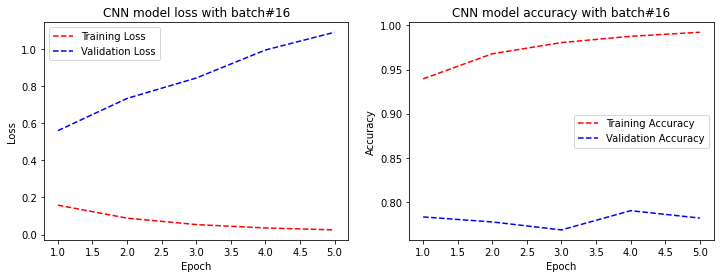

In [39]:
# Don't run this cell if you didn't train the models

if train_models:
  epoch_count = list(range(1, len(train_loss_history)+1))
  x1 = epoch_count
  x2 = epoch_count
  y1_train = train_loss_history
  y1_val = val_loss_history
  y2_train = train_acc_history
  y2_val = val_acc_history

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
  axes[0].plot(x1, y1_train, 'r--')
  axes[0].plot(x1, y1_val, 'b--')
  axes[0].legend(['Training Loss', 'Validation Loss'])
  axes[0].set(xlabel='Epoch', ylabel='Loss')
  axes[0].set_title('CNN model loss with batch#16')
  axes[1].plot(x1, y2_train, 'r--')
  axes[1].plot(x1, y2_val, 'b--')
  axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
  axes[1].set(xlabel='Epoch', ylabel='Accuracy')
  axes[1].set_title('CNN model accuracy with batch#16')
  plt.savefig('cnn_with_batch#16.png')

#### Evaluate model on test data

In [64]:
best_model_hindi.eval()
test_acc_hindi, precision, recall, f1_score = evaluate_sentiment_classifier(best_model_hindi, testloader_hindi)
print(f'Accuracy of Binary sentiment classification for Hindi test dataset: {test_acc_hindi*100:.2f}%')
print(f'Precision of Hindi test dataset: {precision*100:.2f}%')
print(f'Recall of Hindi test dataset: {recall*100:.2f}%')
print(f'F1 score for Hindi test dataset: {f1_score*100:.2f}%')

Accuracy of Binary sentiment classification for Hindi test dataset: 75.47%
Precision of Hindi test dataset: 77.30%
Recall of Hindi test dataset: 69.53%
F1 score for Hindi test dataset: 73.21%


## Task 3b) Preprocess Bengali dataset to make Approximately equal size in sense of size and class distribution as Hindi Dataset

**MUST READ**
#### If you want to sample bengali dataset, then you have to train the word2vec for Bengali dataset again which requires a lot of time and memory that we trained on clusters. That will make `train_bg_word2vec` flag to 1 that will eventually force to train the word2vec for bengali datset. Initailly the flag is set to 0 to load the presampled bengali data and presampled bengali embedding. **Set the value of `train_bg_word2vec = 1` only and only if you want to train word2vec for Bengali dataset**

In [3]:
# keep it 0 if you don't want to train word2vec for bengali dataset once again that will take hours.
train_bg_word2vec = 0

#### Loading the already sampled Bengali dataset if train_bg_word2vec = 0 else sample again and you may need to train word2vec for Bengali dataeset if vocabulary size mismatch due to random sampling(though seed is used)

In [4]:
if train_bg_word2vec==0:
  data = pd.read_csv('bengali_hatespeech_sampled.csv', usecols=['text', 'task_1'])

  dev_bg, val_test_bg = train_test_split(data, test_size = 0.3, random_state = 21)
  val_bg, test_bg = train_test_split(val_test_bg, test_size = 0.5, random_state = 21)

  dev_bg.reset_index(drop = True, inplace=True)
  val_bg.reset_index(drop = True, inplace=True)
  test_bg.reset_index(drop = True, inplace=True)

  print(dev_bg.head())
else:
  df = pd.read_csv('bengali_hatespeech.csv', usecols=['sentence', 'hate'])
  #split data classes
  data_hate = df.iloc[:10000]
  data_not = df.iloc[-20000:]
  data_hate_sampled = data_hate.sample(n = 2500, random_state=1) 
  data_not_sampled = data_not.sample(n = 2200, random_state=1) 
  data_concat = pd.concat([data_hate_sampled, data_not_sampled], ignore_index=True)
  dev = data_concat.sample(frac=1).reset_index(drop=True)
  dev.columns=['text', 'task_1']
  dev['task_1'] = dev['task_1'].replace([1],'HOF')
  dev['task_1'] = dev['task_1'].replace([0],'NOT')
  dev_bg = dev
  dev.to_csv('bengali_hatespeech_sampled.csv')
  print(dev_bg.head())

                                        text task_1
0          বাল শুনেছি তোমার আর -বলতে হবে না,    HOF
1                  মদি মা কে চুদি মাদারি চুদ    HOF
2                             পাপন সালা গুরু    NOT
3             কুকুরের বাচ্চার জন্ম কোন জেলার    HOF
4  বাচ্চা তুই তো করেছিস পাপন শুয়োরের বাচ্চা    HOF


#### Augment the bengali dataset by back translation

In [5]:
df_tr = pd.read_csv('translated-bg.csv', usecols=['text', 'task_1'])

In [6]:
# Concat dev with the translated dataset
dev_bg = pd.concat([dev_bg, df_tr]
                    , ignore_index=True)
dev_bg.drop_duplicates(subset ="text", 
                     keep = 'first', inplace = True) 

print(len(dev_bg))

6563


#### Preprocess the Bengali dataset. Here we remove the punctuations, stopwords and other non-influential words and symbols like 'http' and '@' from the beginning of a word and make word list candidates from the sentences. 

In [7]:
hi = 'stopwords-hi.txt'
bg = 'stopwords-bn.txt'
en = 'stopwords-en.txt'

In [8]:
dev_bg['text'] = dev_bg['text'].apply(lambda x: preprocess(x, hi, bg, en))
dev_bg = dev_bg.dropna()
dev_bg = dev_bg.reset_index(drop=True)

val_bg['text'] = val_bg['text'].apply(lambda x: preprocess(x, hi, bg, en))
val_bg = val_bg.dropna()
val_bg = val_bg.reset_index(drop=True)

test_bg['text'] = test_bg['text'].apply(lambda x: preprocess(x, hi, bg, en))
test_bg = test_bg.dropna()
test_bg = test_bg.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### Augment the dataset by synonyms replacement

In [9]:
aug_n = 9 # How many times to augment the dataset
aug_w_n = 150 # Number of words to replace

np.random.seed(21)
for i in range(aug_n):
	print('Augmentation iteration #: {}'.format(i+1))
	dev_bg = augment_dataset(dev_bg, aug_w_n, 'Synonym-bn.txt')

Augmentation iteration #: 1
Dev size: 8434
Augmentation iteration #: 2
Dev size: 10825
Augmentation iteration #: 3
Dev size: 12570
Augmentation iteration #: 4
Dev size: 13948
Augmentation iteration #: 5
Dev size: 15092
Augmentation iteration #: 6
Dev size: 16082
Augmentation iteration #: 7
Dev size: 16952
Augmentation iteration #: 8
Dev size: 17737
Augmentation iteration #: 9
Dev size: 18448


#### Obtaining the statistics

In [10]:
full_df = pd.concat([dev_bg, val_bg, test_bg])

print('Dataset lenght: {}'.format(len(full_df)))
print('Offensive: {}'.format(len(full_df[full_df['task_1'] == 'HOF'])))
print('Not offensive: {}'.format(len(full_df[full_df['task_1'] == 'NOT'])))
print('Training data: {}'.format(len(dev_bg)))
print('Validation data: {}'.format(len(val_bg)))
print('Test data: {}'.format(len(test_bg)))

del full_df

Dataset lenght: 19853
Offensive: 9277
Not offensive: 10576
Training data: 18448
Validation data: 703
Test data: 702


#### Build the vocabulary avaialable in the dataset

In [11]:
bg_V = build_vocab(dev_bg)
summ = sum(bg_V.values())
len(bg_V)

16503

#### Developing a dictionary that represents the one hot encoding of the words in the vocabulary

In [12]:
if train_bg_word2vec==0: #padding is 1 when we don't want to train word2vec but will load it later
  pad = 1
  onehot_dict_bg = build_onehot(bg_V, pad)
else:
  pad = 0
  onehot_dict_bg = build_onehot(bg_V, pad)


#### Set hyperparameters for training word2vec model for Bengali dataset

In [13]:
# Set hyperparameters
window_size = 5
embedding_size = 300
input_size_bg = len(bg_V) # Onehot vector length
batch_size = 50

# More hyperparameters
learning_rate = 0.05
epochs = 100

#### Create Bengali dataset instance for word2vec and use collate function for batches

In [14]:
dataset_bg = BengaliDataset(dev_bg['text'], window_size, bg_V, summ, onehot_dict_bg)
dataloader = DataLoader(dataset_bg, collate_fn = my_collate, batch_size= batch_size)

#### Create word2vec model instance for Bengali if you want to train the model. 

In [15]:
word2vec_bg_model = Word2Vec(input_size_bg, embedding_size)
word2vec_bg_model.cuda()
if train_bg_word2vec==1:
  print(word2vec_bg_model.fc1.weight.shape)
  word2vec_bg_model.double()
  nn.init.uniform_(word2vec_bg_model.fc1.weight)
  nn.init.uniform_(word2vec_bg_model.fc2.weight)

#### Define optimizer and loss for Word2Vec

In [16]:
# Define optimizer and loss
optimizer = torch.optim.Adam(word2vec_bg_model.parameters(), lr = learning_rate)

criterion = nn.CosineEmbeddingLoss()

## Task 3c) Bengali Embedding  
#### Run the below cell to train the word2vec model. It will take hours to completely train. If training word2vec for Bengali dataset is set to 1 then it will train otherwise, already trained model will be loaded 

In [17]:
if train_bg_word2vec==1: #For training
  train(epochs, dataloader, word2vec_bg_model, criterion, optimizer)
  print("Training finished")
  torch.save(model.state_dict(), 'Word2Vec-bg.model')

else:           #for loading already trained word2vec model 'Word2Vec-bg.model' that should be available in the runtime
  word2vec_bg_model = Word2Vec(input_size_bg, embedding_size) 
  word2vec_bg_model.load_state_dict(torch.load('/content/Word2Vec-bg-aug.model'))
  word2vec_bg_model.eval()
  # Add a column to the first hidden layer matrix of the word2vec model for the padding embedding.
  embeddings = torch.cat((word2vec_bg_model.fc1.weight.detach(), torch.zeros(embedding_size).unsqueeze(1)), dim = 1) # init the padding embedding by zeros
  biases = word2vec_bg_model.fc1.bias.detach()


## Task 3d) Part-0: Build a Bengali sentiment classifier with Bengali embedding 

#### One hot encoding with padding 

In [18]:
pad = 1
onehot_dict_bg = build_onehot(bg_V, pad)
print(onehot_dict_bg[' '])

[0. 0. 0. ... 0. 0. 1.]


#### Getting the insigths of the sentences in sense of the number of words in a sentence for bengali Dataset

count    18448.000000
mean        14.647008
std         20.635304
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max        254.000000
dtype: float64

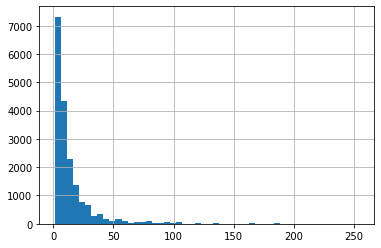

In [19]:
text_len = [len(x) for x in dev_bg['text']]
ax = pd.Series(text_len).hist(bins=50)
fig = ax.get_figure()
fig.savefig('Bengali_dataset_histogram.png')
pd.Series(text_len).describe()

#### From the Histogram above we see that 75% of the sentences are covered with 11 being the size of the words in sentences. We select 20 as the maximum number of words in a sentence considering factor like outliers for Bengali dataset.

#### Set hyperparameters for sentiment analysis on bengali data using already trained hindi model

In [20]:
# Set hyperparameters
batch_size = 64
min_sen_length = 20
embedding_size = 300
input_size_bg = len(bg_V)
output_dim = 1
dropout = 0.5
n_filters = 35
filter_sizes = [2,5,3]

#### We create a custom Bengali dataset and data loader to train the binary classifier

In [21]:
train_dataset_bg = MyDataset(dev_bg, min_sen_length, onehot_dict_bg)
val_dataset_bg = MyDataset(val_bg, min_sen_length, onehot_dict_bg)
test_dataset_bg = MyDataset(test_bg, min_sen_length, onehot_dict_bg)

In [22]:
trainloader = DataLoader(train_dataset_bg, batch_size= batch_size)
valloader = DataLoader(val_dataset_bg, batch_size= batch_size)
testloader = DataLoader(test_dataset_bg, batch_size= batch_size, shuffle = False)

i1, l1 = next(iter(valloader))
print(i1.shape)

torch.Size([64, 20, 16504])


#### Create CNN model instance by importing CNN_BENGALI defined in task2_utils file.

In [23]:
cnn_bengali_bg = CNN_BENGALI(input_size_bg, embedding_size, n_filters, filter_sizes, output_dim, dropout)
cnn_bengali_bg.double()
cnn_bengali_bg.cuda()

CNN_BENGALI(
  (embedding): Linear(in_features=16504, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(2, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copying the biases and embeddings of Bengali word2vec model 

In [24]:
cnn_bengali_bg.embedding.bias.data.copy_(biases)
cnn_bengali_bg.embedding.weight.data.copy_(embeddings)

tensor([[-0.2521, -0.3656, -0.1287,  ...,  1.3743,  0.2100,  0.0000],
        [-0.3558, -1.1004, -0.0721,  ...,  0.3195,  0.0069,  0.0000],
        [ 0.1945, -0.0281, -0.2338,  ...,  0.2620, -0.8092,  0.0000],
        ...,
        [ 4.6841, -1.0397,  0.0622,  ...,  0.4243,  0.7611,  0.0000],
        [ 1.9609, -0.1648, -0.2395,  ...,  0.8899,  0.3538,  0.0000],
        [-0.8628, -0.3637, -0.4946,  ...,  0.1724,  0.0946,  0.0000]],
       device='cuda:0', dtype=torch.float64)

#### Define optimizer and criterion for sentiment analysis training

In [25]:
optimizer = optim.Adam(cnn_bengali_bg.parameters())

criterion = nn.BCEWithLogitsLoss()

#### Train CNN on Bengali data with Bengali Embedding 

In [26]:
# Keep it False unless you want to retrain the model
train_models = False

In [65]:
if train_models:
  N_EPOCHS = 10
  best_valid_loss = float('inf') #Initially sets to infinity
  cnn_bengali_bg.train()

  # Keeping loss and accuracy history of epochs for visualiztion
  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  # Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
  stop_criterion = 0

  for epoch in range(N_EPOCHS):
      #start time of the epoch
      start_time = time.time()
      
      train_loss, train_acc = train_cnn(cnn_bengali_bg, trainloader, optimizer, criterion)
      valid_loss, valid_acc = evaluate_cnn(cnn_bengali_bg, valloader, criterion)
      train_loss_history.append(train_loss)
      train_acc_history.append(train_acc)
      val_loss_history.append(valid_loss)
      val_acc_history.append(valid_acc)

      #End time
      end_time = time.time()
      # calculate elapsed time in mins and seconds
      required_time = end_time - start_time
      mins = int(required_time / 60)
      secs = int(required_time - (mins * 60))
      
      stop_criterion += 1

      #Saving the best model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(cnn_bengali_bg.state_dict(), 'cnn_bengali_bg_model.pt')
          stop_criterion = 0
          best_model_bengali = copy.deepcopy(cnn_bengali_bg)
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

      if stop_criterion == 4:
        print('Early stopping')
        break
else:
  cnn_bengali_bg.load_state_dict(torch.load('cnn_bengali_bg_model.pt'))
  best_model_bengali = cnn_bengali_bg

Epoch: 01 | Epoch Time: 1m 19s
	Train Loss: 0.403 | Train Acc: 81.22%
	 Val. Loss: 0.509 |  Val. Acc: 78.24%
Epoch: 02 | Epoch Time: 1m 19s
	Train Loss: 0.233 | Train Acc: 90.18%
	 Val. Loss: 0.554 |  Val. Acc: 78.66%
Epoch: 03 | Epoch Time: 1m 19s
	Train Loss: 0.162 | Train Acc: 93.62%
	 Val. Loss: 0.590 |  Val. Acc: 77.81%
Epoch: 04 | Epoch Time: 1m 19s
	Train Loss: 0.109 | Train Acc: 95.83%
	 Val. Loss: 0.637 |  Val. Acc: 78.66%
Epoch: 05 | Epoch Time: 1m 19s
	Train Loss: 0.076 | Train Acc: 97.13%
	 Val. Loss: 0.697 |  Val. Acc: 77.96%
Early stopping


#### Visualize Loss and Accuracy for the sentiment classification model on Bengali data with Bengali embedding

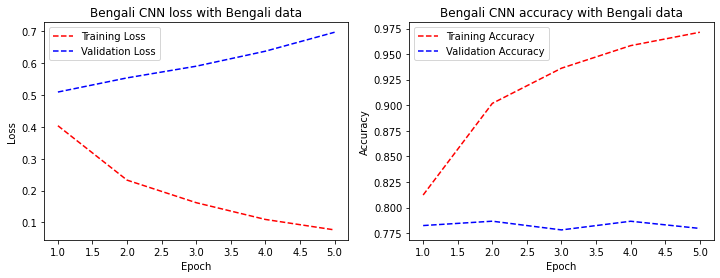

In [66]:
# Don't run this cell if you didn't train the models

if train_models:
  epoch_count = list(range(1, len(train_loss_history)+1))
  x1 = epoch_count
  x2 = epoch_count
  y1_train = train_loss_history
  y1_val = val_loss_history
  y2_train = train_acc_history
  y2_val = val_acc_history

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
  axes[0].plot(x1, y1_train, 'r--')
  axes[0].plot(x1, y1_val, 'b--')
  axes[0].legend(['Training Loss', 'Validation Loss'])
  axes[0].set(xlabel='Epoch', ylabel='Loss')
  axes[0].set_title('Bengali CNN loss with Bengali data')
  axes[1].plot(x1, y2_train, 'r--')
  axes[1].plot(x1, y2_val, 'b--')
  axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
  axes[1].set(xlabel='Epoch', ylabel='Accuracy')
  axes[1].set_title('Bengali CNN accuracy with Bengali data')
  plt.savefig('bengali_cnn_with_bengali_data.png')

#### Evaluation on bengali test dataset of Bengali sentiment classifier

In [67]:
cnn_bengali_bg.eval()
test_acc_on_bengali_test_data, precision, recall, f1_score = evaluate_sentiment_classifier(best_model_bengali, testloader)
print(f'Binary sentiment classification for Bengali test dataset with Bengali model: {test_acc_on_bengali_test_data*100:.2f}%')
print(f'Precision for Bengali test dataset: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset with Bengali model: 77.93%
Precision for Bengali test dataset: 74.57%
Recall for Bengali test dataset: 79.82%
F1 score for Bengali test dataset: 77.10%


## Task 3d: Part-1: Apply the classifier(Hindi Sentiment classifier) to Bengali data(Bengali Embedding that is completely unseen to the sentiment classifier). 

#### One hot encoding with padding 

In [27]:
pad = 1
onehot_dict_bg = build_onehot(bg_V, pad)
print(onehot_dict_bg[' '])

[0. 0. 0. ... 0. 0. 1.]


#### Getting the insigths of the sentences in sense of the number of words in a sentence for bengali Dataset

count    18448.000000
mean        14.647008
std         20.635304
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max        254.000000
dtype: float64

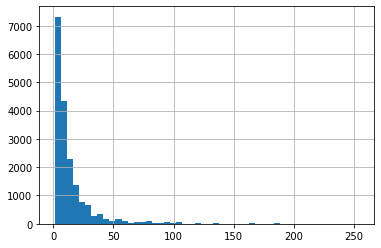

In [28]:
text_len = [len(x) for x in dev_bg['text']]
pd.Series(text_len).hist(bins=50)
pd.Series(text_len).describe()

#### From the Histogram above we see that 75% of the sentences are covered with 11 being the size of the words in sentences. We select 20 as the maximum number of words in a sentence considering factor like outliers for Bengali dataset.

#### Set hyperparameters for sentiment analysis on bengali data using already trained hindi model

In [51]:
# Set hyperparameters
batch_size = 16
min_sen_length = 20
embedding_size = 300
input_size_bg = len(bg_V)
output_dim = 1
dropout = 0.5
n_filters = 35
filter_sizes = [2,3,5]
N_EPOCHS = 10

#### We create a custom Bengali dataset and data loader to train the binary classifier

In [52]:
train_dataset_bg = MyDataset(dev_bg, min_sen_length, onehot_dict_bg)
val_dataset_bg = MyDataset(val_bg, min_sen_length, onehot_dict_bg)
test_dataset_bg = MyDataset(test_bg, min_sen_length, onehot_dict_bg)

In [53]:
trainloader = DataLoader(train_dataset_bg, batch_size= batch_size)
valloader = DataLoader(val_dataset_bg, batch_size= batch_size)
testloader = DataLoader(test_dataset_bg, batch_size= batch_size, shuffle = False)

i1, l1 = next(iter(valloader))
print(i1.shape)

torch.Size([16, 20, 16504])


#### Create CNN model instance by importing CNN_BENGALI defined in task2_utils file.

In [54]:
cnn_bengali_hi = CNN_BENGALI(input_size_bg, embedding_size, n_filters, filter_sizes, output_dim, dropout)
cnn_bengali_hi.double()
cnn_bengali_hi.cuda()

CNN_BENGALI(
  (embedding): Linear(in_features=16504, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(2, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copying the biases and embeddings of Bengali word2vec model 

In [55]:
cnn_bengali_hi.embedding.bias.data.copy_(biases)
cnn_bengali_hi.embedding.weight.data.copy_(embeddings)

tensor([[-0.2521, -0.3656, -0.1287,  ...,  1.3743,  0.2100,  0.0000],
        [-0.3558, -1.1004, -0.0721,  ...,  0.3195,  0.0069,  0.0000],
        [ 0.1945, -0.0281, -0.2338,  ...,  0.2620, -0.8092,  0.0000],
        ...,
        [ 4.6841, -1.0397,  0.0622,  ...,  0.4243,  0.7611,  0.0000],
        [ 1.9609, -0.1648, -0.2395,  ...,  0.8899,  0.3538,  0.0000],
        [-0.8628, -0.3637, -0.4946,  ...,  0.1724,  0.0946,  0.0000]],
       device='cuda:0', dtype=torch.float64)

#### Copying the weights and biases from **HINDI** CNN model that is already trained for creating Bengali CNN model. That means `cnn_bengali` model has Bengali word2vec as embedding layer and all other layers are from the Hindi CNN model. 

In [56]:
best_model_hindi = CNN_HINDI(input_size_hi, embedding_size, n_filters, filter_sizes, output_dim, dropout)
best_model_hindi.double()
best_model_hindi.cuda()
best_model_hindi.load_state_dict(torch.load('cnn_hindi_model.pt'))

<All keys matched successfully>

In [57]:
cnn_bengali_hi.conv_0.bias.data.copy_(best_model_hindi.conv_0.bias)
cnn_bengali_hi.conv_0.weight.data.copy_(best_model_hindi.conv_0.weight)
cnn_bengali_hi.conv_1.bias.data.copy_(best_model_hindi.conv_1.bias)
cnn_bengali_hi.conv_1.weight.data.copy_(best_model_hindi.conv_1.weight)
cnn_bengali_hi.conv_2.bias.data.copy_(best_model_hindi.conv_2.bias)
cnn_bengali_hi.conv_2.weight.data.copy_(best_model_hindi.conv_2.weight)
cnn_bengali_hi.fc.bias.data.copy_(best_model_hindi.fc.bias)
cnn_bengali_hi.fc.weight.data.copy_(best_model_hindi.fc.weight)

tensor([[-0.0246,  0.1665, -0.1480,  0.0858, -0.0544,  0.1417,  0.1312,  0.0941,
          0.1105,  0.1446,  0.1603,  0.0203, -0.0794, -0.1147, -0.0907, -0.0124,
         -0.0849, -0.1028, -0.0482, -0.0908, -0.0104, -0.1294, -0.1138, -0.0117,
          0.0564,  0.0133, -0.1201, -0.0994, -0.1374,  0.1542, -0.0750,  0.0461,
          0.0078,  0.0822, -0.1049, -0.0809,  0.0825, -0.1768, -0.1036, -0.0358,
         -0.0962, -0.1072, -0.0837,  0.1338,  0.0695, -0.0278,  0.0170,  0.1607,
         -0.0528, -0.0527, -0.0366,  0.0368, -0.1163,  0.0146, -0.0383, -0.1148,
         -0.1422,  0.1738,  0.1161, -0.0016,  0.0097,  0.0016,  0.0235, -0.1034,
          0.1634, -0.0020,  0.0103, -0.0839,  0.0305,  0.0813,  0.0066, -0.0863,
         -0.0566, -0.0920, -0.0183,  0.1645,  0.1635, -0.0223, -0.0879,  0.1196,
         -0.1265,  0.1110,  0.0317,  0.1723, -0.1437,  0.0832, -0.0872,  0.0929,
         -0.1523,  0.0616,  0.0822,  0.1467, -0.1058, -0.0750,  0.0314, -0.1128,
         -0.0087, -0.1131,  

#### Accuracy of Sentiment classifier while Bengali embedding is used

In [58]:
cnn_bengali_hi.eval()
test_acc_on_bengali_test_data, precision, recall, f1_score = evaluate_sentiment_classifier(cnn_bengali_hi, testloader)
print(f'Binary sentiment classification for Bengali test dataset with Hindi model: {test_acc_on_bengali_test_data*100:.2f}%')
print(f'Precision for Bengali test dataset with Hindi model: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset with Hindi model: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset with Hindi model: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset with Hindi model: 49.53%
Precision for Bengali test dataset with Hindi model: 43.95%
Recall for Bengali test dataset with Hindi model: 29.97%
F1 score for Bengali test dataset with Hindi model: 35.64%


The accuracy is less than 0.5 meaning that the model performed worse than random predicting, but that is what we expected to happen. 

We would expect the model to perform better if at least the word embeddings of Bengali text would be approximetely equal to the ones of Hindi text. The probability of this situation is extremely low at least due to the weight space symmetry or different contextual probabilities of the words of 2 different languages. 

## Task 3d) Retrain model with Bengali data

#### Define optimizer and criterion for sentiment analysis retraining

In [59]:
optimizer = optim.Adam(cnn_bengali_hi.parameters())

criterion = nn.BCEWithLogitsLoss()

#### Retrain CNN on Bengali data 

In [61]:
# Keep it False unless you want to train the models

train_models = False

In [62]:
if train_models:
  N_EPOCHS = 10
  best_valid_loss = float('inf') #Initially sets to infinity
  cnn_bengali_hi.train()

  # Keeping loss and accuracy history of epochs for visualiztion
  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  # Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
  stop_criterion = 0

  for epoch in range(N_EPOCHS):
      #start time of the epoch
      start_time = time.time()
      
      train_loss, train_acc = train_cnn(cnn_bengali_hi, trainloader, optimizer, criterion)
      valid_loss, valid_acc = evaluate_cnn(cnn_bengali_hi, valloader, criterion)
      train_loss_history.append(train_loss)
      train_acc_history.append(train_acc)
      val_loss_history.append(valid_loss)
      val_acc_history.append(valid_acc)

      #End time
      end_time = time.time()
      # calculate elapsed time in mins and seconds
      required_time = end_time - start_time
      mins = int(required_time / 60)
      secs = int(required_time - (mins * 60))
      
      stop_criterion += 1

      #Saving the best model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(cnn_bengali_hi.state_dict(), 'cnn_hindi_retrained_on_bengali-model.pt')
          stop_criterion = 0
          best_cnn_bengali_hi = copy.deepcopy(cnn_bengali_hi)

      print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

      if stop_criterion == 4:
        print('Early stopping')
        break
else:
  cnn_bengali_hi.load_state_dict(torch.load('cnn_hindi_retrained_on_bengali-model.pt'))
  best_cnn_bengali_hi = cnn_bengali_hi 

Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 0.428 | Train Acc: 79.00%
	 Val. Loss: 0.618 |  Val. Acc: 76.52%
Epoch: 02 | Epoch Time: 1m 24s
	Train Loss: 0.241 | Train Acc: 90.04%
	 Val. Loss: 0.666 |  Val. Acc: 77.36%
Epoch: 03 | Epoch Time: 1m 24s
	Train Loss: 0.167 | Train Acc: 92.90%
	 Val. Loss: 0.671 |  Val. Acc: 80.09%
Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 0.122 | Train Acc: 95.20%
	 Val. Loss: 0.803 |  Val. Acc: 78.83%
Epoch: 05 | Epoch Time: 1m 24s
	Train Loss: 0.091 | Train Acc: 96.42%
	 Val. Loss: 0.853 |  Val. Acc: 79.68%
Early stopping


#### Visualize Loss and Accuracy for the model with Bengali dataset after retraining

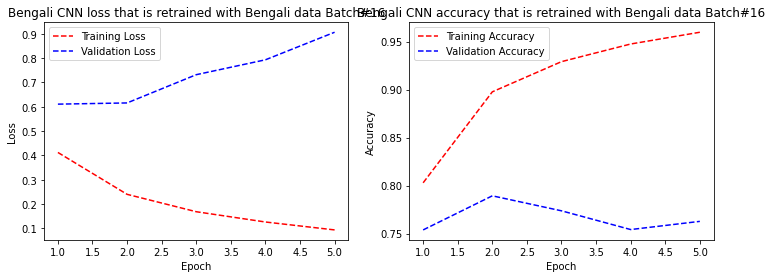

In [ ]:
# Don't run this unless you trained the models

if train_models:
  epoch_count = list(range(1, len(train_acc_history)+1))
  x1 = epoch_count
  x2 = epoch_count
  y1_train = train_loss_history
  y1_val = val_loss_history
  y2_train = train_acc_history
  y2_val = val_acc_history

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
  axes[0].plot(x1, y1_train, 'r--')
  axes[0].plot(x1, y1_val, 'b--')
  axes[0].legend(['Training Loss', 'Validation Loss'])
  axes[0].set(xlabel='Epoch', ylabel='Loss')
  axes[0].set_title('Bengali CNN loss that is retrained with Bengali data Batch#16')
  axes[1].plot(x1, y2_train, 'r--')
  axes[1].plot(x1, y2_val, 'b--')
  axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
  axes[1].set(xlabel='Epoch', ylabel='Accuracy')
  axes[1].set_title('Bengali CNN accuracy that is retrained with Bengali data Batch#16')
  plt.savefig('bengali_cnn_after_retrained_batch#16.png')

We see that the accuracy improved a lot and became approximately equal to the one of Hindi model.

#### Evaluation on bengali test dataset of Sentiment classifier after retraining with bengali Embedding

In [63]:
cnn_bengali_hi.eval()
test_acc_on_bengali_test_data_retrained, precision, recall, f1_score = evaluate_sentiment_classifier(best_cnn_bengali_hi, testloader)
print(f'Binary sentiment classification for Bengali test dataset after retraining: {test_acc_on_bengali_test_data_retrained*100:.2f}%')
print(f'Precision for Bengali test dataset after retraining: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset after retraining: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset after retraining: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset after retraining: 77.21%
Precision for Bengali test dataset after retraining: 81.27%
Recall for Bengali test dataset after retraining: 66.36%
F1 score for Bengali test dataset after retraining: 73.06%
